<a href="https://colab.research.google.com/github/Chinmayi-Bachu/Object_detection/blob/main/training_yolomodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Jun 24 12:31:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Upload Image Dataset and Prepare Training Data

In [2]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

Python script that will automatically create the required folder structure and randomly move 90% of dataset to the "train" folder and 10% to the "validation" folder.

In [3]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-06-24 12:39:03--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-06-24 12:39:03 (39.4 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 452
Number of annotation files: 452
Images moving to train: 406
Images moving to validation: 46


Install Requirements (Ultralytics)

In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

Configure Training

In [5]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 52
names:
- 10 of Clubs
- 10 of Diamonds
- 10 of Hearts
- 10 of Spades
- 2 of Clubs
- 2 of Diamonds
- 2 of Hearts
- 2 of Spades
- 3 of Clubs
- 3 of Diamonds
- 3 of Hearts
- 3 of Spades
- 4 of Clubs
- 4 of Diamonds
- 4 of Hearts
- 4 of Spades
- 5 of Clubs
- 5 of Diamonds
- 5 of Hearts
- 5 of Spades
- 6 of Clubs
- 6 of Diamonds
- 6 of Hearts
- 6 of Spades
- 7 of Clubs
- 7 of Diamonds
- 7 of Hearts
- 7 of Spades
- 8 of Clubs
- 8 of Diamonds
- 8 of Hearts
- 8 of Spades
- 9 of Clubs
- 9 of Diamonds
- 9 of Hearts
- 9 of Spades
- Ace of Clubs
- Ace of Diamonds
- Ace of Hearts
- Ace of Spades
- Jack of Clubs
- Jack of Diamonds
- Jack of Hearts
- Jack of Spades
- King of Clubs
- King of Diamonds
- King of Hearts
- King of Spades
- Queen of Clubs
- Queen of Diamonds
- Queen of Hearts
- Queen of Spades


Train Model

In [6]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=40 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 18.4M/18.4M [00:00<00:00, 158MB/s]
Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, i

Test Model

In [7]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,432,924 parameters, 0 gradients, 21.4 GFLOPs

image 1/46 /content/data/validation/images/008ce697-H55.jpg: 640x448 1 5 of Hearts, 44.6ms
image 2/46 /content/data/validation/images/05b9c836-C66.jpg: 640x416 1 5 of Clubs, 1 9 of Clubs, 45.6ms
image 3/46 /content/data/validation/images/106fdec3-q15.jpg: 640x416 1 Queen of Diamonds, 11.8ms
image 4/46 /content/data/validation/images/13ac4374-C77.jpg: 640x544 1 5 of Clubs, 1 7 of Clubs, 45.8ms
image 5/46 /content/data/validation/images/144173b0-s65.jpg: 640x480 1 6 of Spades, 44.5ms
image 6/46 /content/data/validation/images/1587e872-wefwef.jpg: 640x480 1 Queen of Hearts, 12.4ms
image 7/46 /content/data/validation/images/18b8cae6-k13.jpg: 640x512 1 King of Hearts, 44.6ms
image 8/46 /content/data/validation/images/1a36a281-d510.jpg: 544x640 (no detections), 53.1ms
image 9/46 /content/data/validation/images/2b29e650-H51.jpg

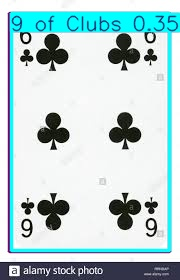

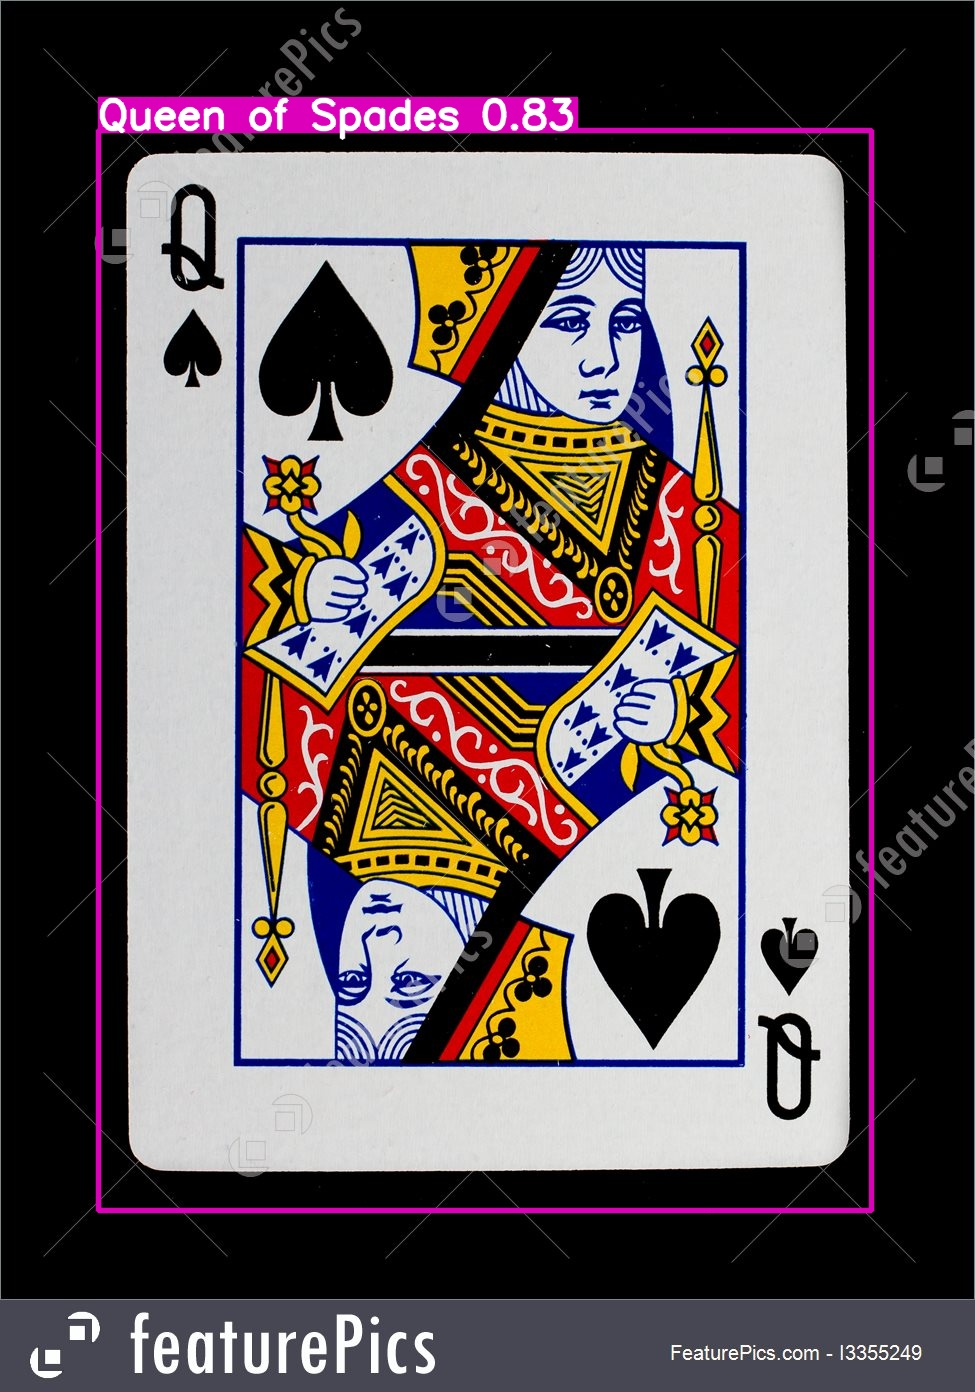

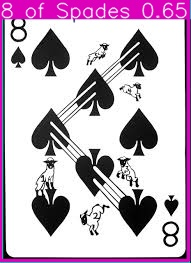

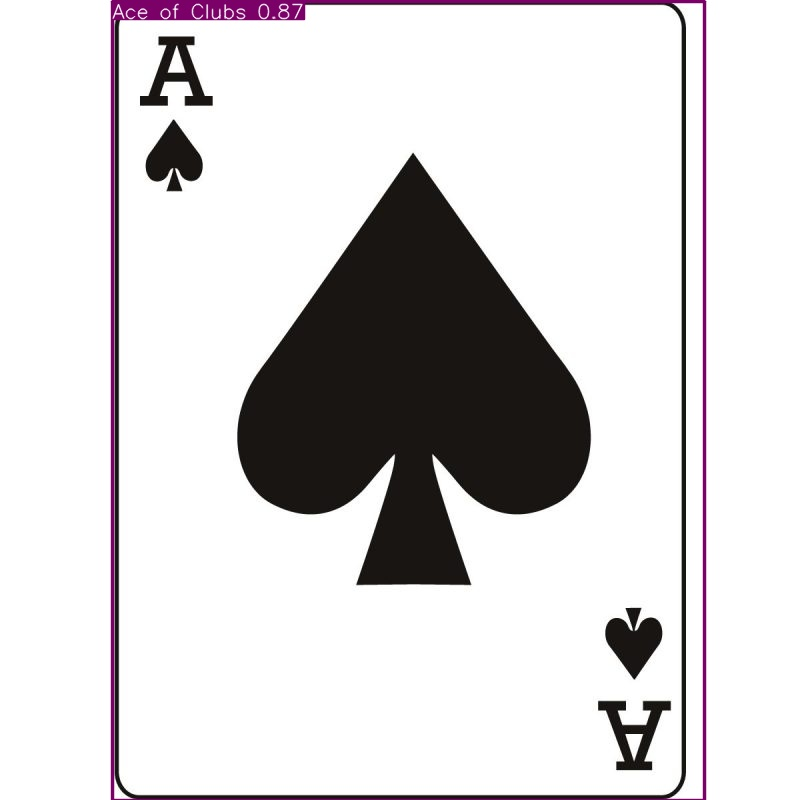

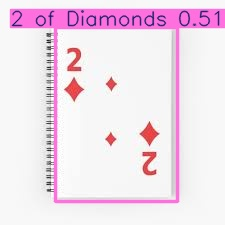

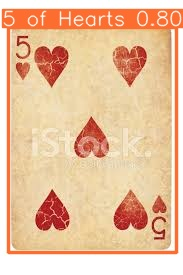

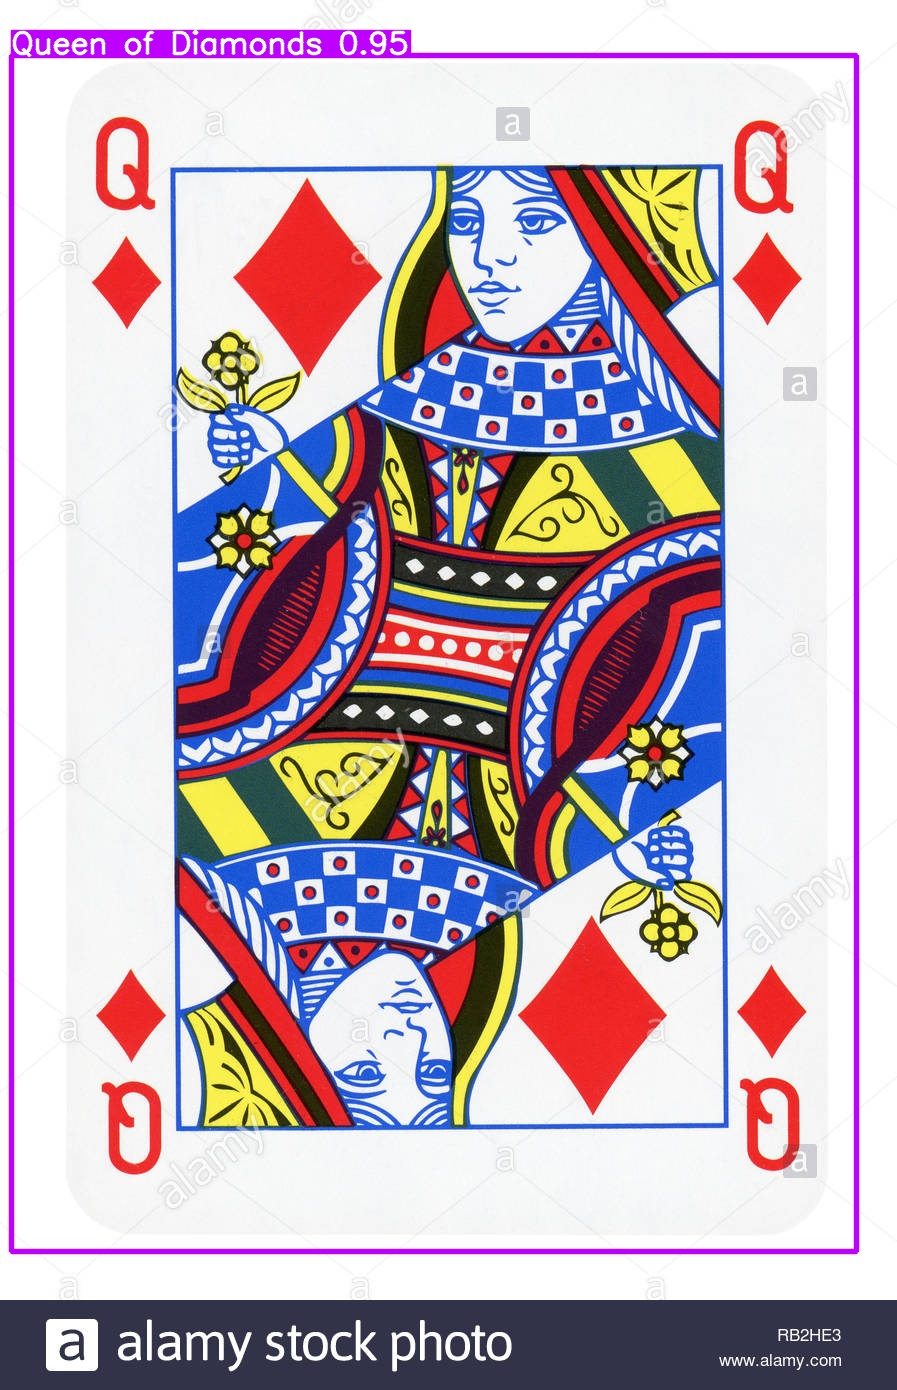

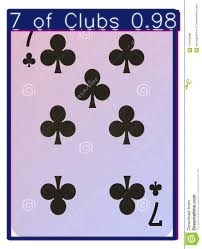

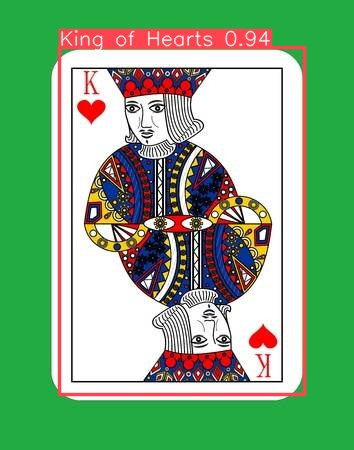

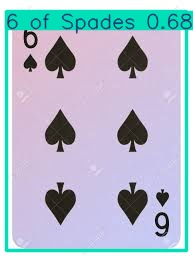

In [10]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


Deploy Model

In [11]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

/content/my_model
  adding: my_model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/confusion_matrix_normalized.png (deflated 20%)
  adding: train/R_curve.png (deflated 13%)
  adding: train/labels.jpg (deflated 41%)
  adding: train/train_batch2.jpg (deflated 14%)
  adding: train/val_batch0_labels.jpg (deflated 20%)
  adding: train/results.csv (deflated 60%)
  adding: train/results.png (deflated 7%)
  adding: train/train_batch1.jpg (deflated 14%)
  adding: train/args.yaml (deflated 53%)
  adding: train/train_batch782.jpg (deflated 17%)
  adding: train/train_batch0.jpg (deflated 13%)
  adding: train/val_batch1_pred.jpg (deflated 19%)
  adding: train/P_curve.png (deflated 12%)
  adding: train/F1_curve.png (deflated 10%)
  adding: train/PR_curve.png (deflated 28%)
  adding: train/labels_correlogram.jpg (deflated 42%)
  adding: train/confusion_matrix.png (deflated 20%)
  adding: train/train_batch781.jpg (deflated 24%)
  adding: train/val_batch0_pred.jpg (deflated 20%)
  addin

In [12]:
# This takes forever for some reason, you can also just download the model from the sidebar
from google.colab import files

files.download('/content/my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>